In [1]:
import requests
from config import API_KEY
import pandas as pd
import numpy as np

## Get Data from eia API

In [2]:
url = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPMRR_PTE_YORD_DPG.W"

In [3]:
df = pd.DataFrame(requests.get(url).json()['series'][0]['data'])

In [4]:
df.rename(columns = {0:"week", 1:"price"}, inplace = True)

In [5]:
pd.to_datetime(df['week'])

0      2020-11-09
1      2020-11-02
2      2020-10-26
3      2020-10-19
4      2020-10-12
          ...    
1062   2000-07-03
1063   2000-06-26
1064   2000-06-19
1065   2000-06-12
1066   2000-06-05
Name: week, Length: 1067, dtype: datetime64[ns]

In [6]:
df['week'] = pd.to_datetime(df['week'])

<AxesSubplot:xlabel='week'>

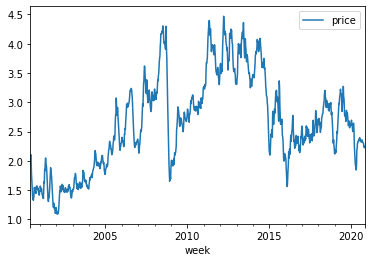

In [7]:
df.plot(x = 'week', y = 'price')

In [8]:
df['price'].diff()

0         NaN
1      -0.014
2       0.026
3      -0.016
4       0.034
        ...  
1062    0.098
1063    0.203
1064    0.119
1065   -0.017
1066   -0.142
Name: price, Length: 1067, dtype: float64

In [9]:
df['change'] = df['price'].diff()

In [10]:
df.dropna(inplace =True)

<AxesSubplot:xlabel='week'>

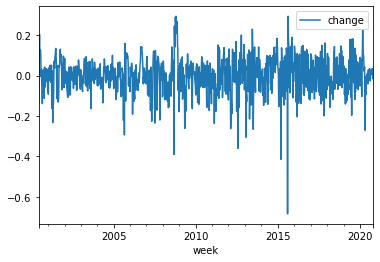

In [11]:
df.plot(x = 'week', y='change')

## Processs the data

In [12]:
#train test split
train_size = int(0.8 * len(df))
df_train = df.iloc[0:train_size]
df_test = df.iloc[train_size:]

In [13]:
df_train

,week,price,change
1,2020-11-02,2.223,-0.014
2,2020-10-26,2.249,0.026
3,2020-10-19,2.233,-0.016
4,2020-10-12,2.267,0.034
5,2020-10-05,2.301,0.034
...,...,...,...
848,2004-08-09,1.932,-0.021
849,2004-08-02,1.912,-0.020
850,2004-07-26,1.937,0.025
851,2004-07-19,1.980,0.043


In [14]:
df_test

,week,price,change
853,2004-07-05,1.918,-0.027
854,2004-06-28,1.936,0.018
855,2004-06-21,1.951,0.015
856,2004-06-14,2.027,0.076
857,2004-06-07,2.109,0.082
...,...,...,...
1062,2000-07-03,1.786,0.098
1063,2000-06-26,1.989,0.203
1064,2000-06-19,2.108,0.119
1065,2000-06-12,2.091,-0.017


In [15]:
#function for making windows
def make_windows(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
time_steps = 10
X_train, y_train = make_windows(df_train[['change']], df_train['change'], time_steps)
X_test, y_test = make_windows(df_test[['change']], df_test['change'], time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(842, 10, 1) (842,) (204, 10, 1) (204,)


## Build Model

In [17]:
from tensorflow import keras

In [18]:
model = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    keras.layers.LSTM(units = 64, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True),
    keras.layers.LSTM(units = 32, input_shape=(X_train.shape[1], 64), return_sequences=False),
    # Shape => [batch, time, features]
    keras.layers.Dense(units=1)
])

In [19]:
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [20]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    verbose=1,
    shuffle=False
)

Epoch 1/25
27/27 [==============================] - 1s 29ms/step - loss: 0.0093
Epoch 2/25
27/27 [==============================] - 1s 20ms/step - loss: 0.0090
Epoch 3/25
27/27 [==============================] - 1s 20ms/step - loss: 0.0089
Epoch 4/25
27/27 [==============================] - 1s 20ms/step - loss: 0.0089
Epoch 5/25
27/27 [==============================] - 1s 20ms/step - loss: 0.0088
Epoch 6/25
27/27 [==============================] - 1s 20ms/step - loss: 0.0088
Epoch 7/25
27/27 [==============================] - 1s 20ms/step - loss: 0.0087
Epoch 8/25
27/27 [==============================] - 1s 20ms/step - loss: 0.0087
Epoch 9/25
27/27 [==============================] - 1s 21ms/step - loss: 0.0087
Epoch 10/25
27/27 [==============================] - 1s 21ms/step - loss: 0.0086
Epoch 11/25
27/27 [==============================] - 1s 20ms/step - loss: 0.0086
Epoch 12/25
27/27 [==============================] - 0s 18ms/step - loss: 0.0086
Epoch 13/25
27/27 [==================

In [21]:
y_pred = model.predict(X_test)

In [37]:
y_pred

array([[-2.21967101e-02],
       [-2.42202487e-02],
       [-1.10866623e-02],
       [-1.74425300e-02],
       [-1.10768564e-02],
       [-1.17916409e-02],
       [-2.49244776e-02],
       [-1.90701019e-02],
       [ 9.33312438e-03],
       [-1.03080701e-02],
       [-8.86448752e-03],
       [-8.92197154e-03],
       [-5.17477188e-03],
       [-1.67846922e-02],
       [ 5.82049228e-03],
       [-1.83188003e-02],
       [-1.78385433e-02],
       [-2.03536619e-02],
       [-1.99495014e-02],
       [ 3.05911293e-04],
       [-8.39754101e-03],
       [-4.69576940e-03],
       [-2.18539964e-04],
       [ 5.90754952e-03],
       [-8.05038866e-03],
       [ 7.67559279e-03],
       [ 1.68311950e-02],
       [-1.16381180e-02],
       [ 9.82586108e-03],
       [-4.49796207e-05],
       [-9.00669489e-03],
       [ 9.59476456e-04],
       [ 1.60850100e-02],
       [ 2.25624014e-02],
       [ 2.30834098e-03],
       [-3.31901712e-04],
       [ 7.86168315e-03],
       [-4.54781987e-02],
       [-1.7

In [22]:
import matplotlib.pyplot as plt

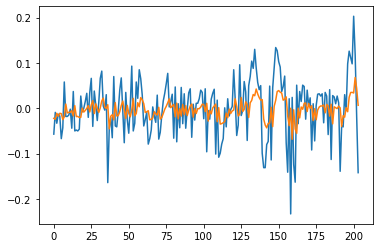

In [23]:
fig, ax = plt.subplots()
ax.plot(y_test)
ax.plot(y_pred)

In [24]:
y_err = np.abs(y_test.reshape(204 ,1) - y_pred)

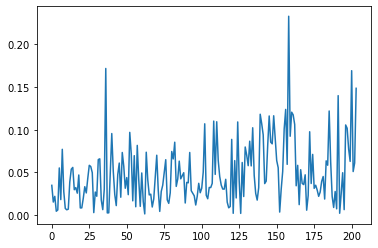

In [25]:
plt.plot(y_err)

In [26]:
np.sum(y_err[0:4])

0.0763794062957166

In [27]:
df_test

,week,price,change
853,2004-07-05,1.918,-0.027
854,2004-06-28,1.936,0.018
855,2004-06-21,1.951,0.015
856,2004-06-14,2.027,0.076
857,2004-06-07,2.109,0.082
...,...,...,...
1062,2000-07-03,1.786,0.098
1063,2000-06-26,1.989,0.203
1064,2000-06-19,2.108,0.119
1065,2000-06-12,2.091,-0.017


In [28]:
df_test['price'].iloc[0]

1.918

In [29]:
price_pred = [ 1.918 + np.sum(y_pred[1:n]) for n in range(1,len(df_test)) ]

In [30]:
price_pred

[1.918,
 1.8937797513157129,
 1.8826930880844592,
 1.865250559926033,
 1.8541737072467803,
 1.8423820682168006,
 1.8174575887918472,
 1.7983874850273132,
 1.8077206038236617,
 1.797412531852722,
 1.7885480396747588,
 1.779626073718071,
 1.7744513027667999,
 1.7576666049957275,
 1.7634871028661727,
 1.7451683007478713,
 1.7273297630548476,
 1.706976103067398,
 1.687026607275009,
 1.6873325132131576,
 1.678934978723526,
 1.674239205598831,
 1.6740206651687621,
 1.6799282156229018,
 1.671877818584442,
 1.679553406715393,
 1.6963845961093902,
 1.68474647629261,
 1.6945723317861556,
 1.6945273451805114,
 1.6855206512212753,
 1.686480122089386,
 1.7025651507377624,
 1.7251275502443313,
 1.7274358891248702,
 1.7271039806604385,
 1.7349656693935394,
 1.6894874744415282,
 1.6720740519762038,
 1.6579040460586547,
 1.6323492102622985,
 1.644850539445877,
 1.6278482847213744,
 1.6117936544418334,
 1.6042996220588683,
 1.610355066537857,
 1.6262256376743316,
 1.6235579125881194,
 1.601280438184738,

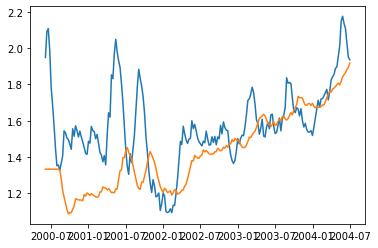

In [31]:
fig, ax = plt.subplots()
ax.plot(df_test['week'].iloc[1:],df_test['price'].iloc[1:])
ax.plot(df_test['week'].iloc[1:], price_pred[:214])

## Save Model

In [32]:
model.save("test_model.h5")

In [33]:
#!tensorflowjs_converter --input_format keras "test_model.h5" ./jsmodel

2020-11-12 13:48:49.064289: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-11-12 13:48:49.065621: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [56]:
data = np.array([0.030000000000000027, -0.004999999999999893, 0.09799999999999986, 0.1260000000000001, 0.11199999999999988, 0.09800000000000009, 0.20300000000000007, 0.119, -0.016999999999999904, -0.14200000000000013])

In [61]:
data = data.reshape(1,10,1)

In [42]:
import tensorflow as tf

In [62]:
model.predict(data)

array([[-0.03183652]], dtype=float32)

In [63]:
X_test[-1]

array([[-0.041],
       [ 0.03 ],
       [-0.005],
       [ 0.098],
       [ 0.126],
       [ 0.112],
       [ 0.098],
       [ 0.203],
       [ 0.119],
       [-0.017]])